In [41]:
import sys
sys.path.append('../')

In [42]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [43]:
from pathlib import Path

import torch
from PIL import Image
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
from tqdm import tqdm

from models.stylegan2_generator import StyleGAN2Generator
from models.stylegan2_generator_wconditioned import StyleGAN2GeneratorW
from models.chexplaining_models import Encoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Test torch in GPU
x = torch.randn((1, 1)).to(device)
print(2 * x)

tensor([[-0.4314]], device='cuda:0')


In [44]:
DATA_DIR = Path('../.data/synthetic')
# HAMMER_WORK_DIRS = Path('../work_dirs/')
HAMMER_WORK_DIRS = Path('/mnt/data/gregschuit/work_dirs/')

In [45]:
paths = {
    'stylegan2_imagenome256_pa_resized': HAMMER_WORK_DIRS / 'stylegan2_imagenome256_pa_resized/checkpoints/best-fid50k_full-checkpoint-064000.pth',
    'c_stylegan2_imagenome256_device_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_device_pa_resized/checkpoints/best-fid50k_full-checkpoint-064000.pth',
    'c_stylegan2_imagenome256_lung_opacity_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_lung_opacity_pa_resized/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'c_stylegan2_imagenome256_atelectasis_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_atelectasis_pa_resized/checkpoints/best-fid50k_full-checkpoint-070400.pth',
    'c_stylegan2_imagenome256_enlarged_cardiac_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_enlarged_cardiac_pa_resized/checkpoints/best-fid50k_full-checkpoint-070400.pth',
    'c_stylegan2_imagenome256_pleural_effusion_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_pleural_effusion_pa_resized/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w10': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w10/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w20': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w20/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w40': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w40/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w60': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w60/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w80': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w80/checkpoints/best-fid50k_full-checkpoint-070400.pth',

    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_softbb_w40': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_softbb_w40/checkpoints/best-fid50k_full-checkpoint-075000.pth',
}

def load_generator(path):
    checkpoint = torch.load(path, map_location='cpu')
    init_kwargs = checkpoint['model_kwargs_init']['generator_smooth']
    del init_kwargs['model_type']
    model_kwargs_val = checkpoint['model_kwargs_val']['generator_smooth']
    generator = StyleGAN2GeneratorW(**init_kwargs)
    generator.load_state_dict(checkpoint['models']['generator_smooth'])
    generator.eval()
    return generator, model_kwargs_val


def load_encoder(path):
    checkpoint = torch.load(path, map_location='cpu')
    init_kwargs = checkpoint['model_kwargs_init']['encoder']
    del init_kwargs['model_type']
    model_kwargs_val = checkpoint['model_kwargs_val']['encoder']
    encoder = Encoder(**init_kwargs)
    encoder.load_state_dict(checkpoint['models']['encoder'])
    encoder.eval()
    return encoder, model_kwargs_val


def generate_images(generator, label, batch_size, model_kwargs, device='cpu'):
    """Uses the generator to generate a batch of images.

    Args:
        generator (StyleGAN2Generator): The generator to use.
        label (List[int]): The label to use in one-hot encoding. This list will be 
            repeated to match the batch size.
        batch_size (int): The number of images to generate.
        model_kwargs (dict): The model kwargs to be passed to the model on inference.

    """
    codes = torch.randn((batch_size, 512)).to(device)
    labels = torch.tensor([label] * batch_size).to(device)
    with torch.no_grad():
        out = generator(codes, label=labels, **model_kwargs)
    return out['image'], out['z'], out['w'], out['wp']


def process_generated_tensor(img_tensor: torch.Tensor) -> Image:
    """Converts a generated image tensor to a PIL image.

    The image tensor is expected to be approx. in the range [-1, 1], as is the case
    with the StyleGAN2Generator output.

    Args:
        img_tensor (torch.Tensor): The image tensor to convert.

    Returns:
        torch.Tensor: The converted image, in tensor format.

    """
    _min, _max = -1, 1
    img_tensor = torch.clamp(img_tensor, _min, _max)
    img_tensor = (img_tensor - _min) / (_max - _min)
    return img_tensor

In [46]:
sys.path.append('../../thesis/src/')

In [47]:
# p = paths['r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w10']
# p = '/home/gregschuit/projects/Hammer/work_dirs/emb_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_refactored_continue_6/checkpoints/checkpoint-075000.pth'
# p = '/home/gregschuit/projects/Hammer/work_dirs/emb_r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_continue_2/checkpoints/checkpoint-064000.pth'
p = '/home/gregschuit/projects/Hammer/work_dirs/w_emb_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized/checkpoints/checkpoint-019200.pth'
encoder, encoder_kwargs = load_encoder(p)
generator, model_kwargs = load_generator(p)

In [48]:
out = generate_images(generator, [1, 0], 2, model_kwargs)

In [49]:
images = out[0]
processed = process_generated_tensor(images)

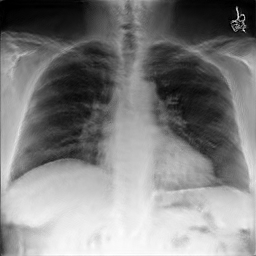

In [50]:
to_pil_image(processed[0])

In [51]:
from torchvision.transforms.functional import pil_to_tensor

In [52]:
batch_tensor = processed[:1]
# batch_tensor = torch.tensor(batch_tensor, dtype=torch.float32)

In [53]:
batch_tensor

tensor([[[[0.2443, 0.2434, 0.1477,  ..., 0.0228, 0.0357, 0.1235],
          [0.1028, 0.0435, 0.0000,  ..., 0.0149, 0.0000, 0.0724],
          [0.0198, 0.0000, 0.0000,  ..., 0.0130, 0.0162, 0.0592],
          ...,
          [0.2301, 0.2900, 0.2872,  ..., 0.5814, 0.6461, 0.7366],
          [0.2238, 0.3785, 0.3492,  ..., 0.6255, 0.7060, 0.7062],
          [0.2233, 0.3413, 0.4133,  ..., 0.5677, 0.5354, 0.5390]]]])

In [54]:
z_emb = encoder(batch_tensor)

In [55]:
z_emb

tensor([[-1.2665e-01,  2.0152e-01,  3.9120e-01,  1.2406e+00,  1.0517e-01,
         -2.9291e-01, -4.3477e-01,  2.5807e-01,  1.1626e-01, -4.3710e-02,
         -5.1150e-01,  6.3550e-02,  1.8293e-01,  3.4314e-01, -9.0385e-02,
          3.8244e-01,  7.0330e-02,  2.4861e-01,  6.3314e-02, -2.4043e-01,
          1.0939e-01, -5.2147e-02,  5.9815e-01,  2.1384e+00,  4.2787e-01,
          4.1399e-01,  2.2607e-01,  2.3860e-02,  6.6936e-02,  3.1254e-02,
          1.4133e-01,  7.6913e-01,  9.4511e-01,  1.0464e-01,  1.1833e-01,
          6.0471e-01, -3.9737e-01,  1.2393e+00,  1.7995e-01,  1.1871e-01,
          1.3878e-01,  4.2610e-01,  1.5482e+00,  5.9908e-01,  9.4125e-01,
          2.1170e-01,  3.4752e-04,  1.0345e+00, -4.2901e-01,  4.1961e-01,
         -2.9665e-01,  4.0517e-01, -2.2426e-01,  6.7834e-01,  3.0246e-01,
          3.2084e-01, -3.5318e-03,  2.9482e-01,  1.5686e+00, -4.9044e-01,
          1.1457e+00,  7.9170e-01,  1.8194e-01,  7.9863e-01,  1.2184e-01,
          1.7166e-01,  3.1528e-01, -2.

In [56]:
codes = z_emb
labels = torch.tensor([[1, 0]] * 1)
with torch.no_grad():
    out_recon = generator(codes, label=labels, **model_kwargs)

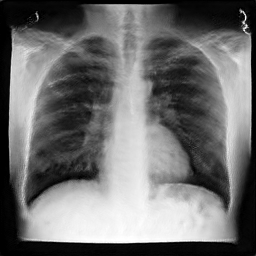

In [57]:
to_pil_image(process_generated_tensor(out_recon['image'][0]))

In [58]:
# Medir Reconstrucción de la imagen
from torch.nn.functional import l1_loss


def test_inversion(N, checkpoint_path, label):
    encoder, encoder_kwargs = load_encoder(checkpoint_path)
    generator, model_kwargs = load_generator(checkpoint_path)

    # Source images
    y_source = [0, 0]
    y_source[label] = 1
    out = generate_images(generator, y_source, N, model_kwargs)
    img_source = process_generated_tensor(out[0])

    # Encode
    z1 = encoder(img_source)
    y1 = torch.tensor([[1, 0]] * z1.shape[0])

    # Generate
    with torch.no_grad():
        out_recon = generator(z1, label=y1, **model_kwargs)
    img_recon = process_generated_tensor(out_recon['image'])

    # Encode again
    z2 = encoder((img_recon))

    # Compute L1 loss
    loss_x = l1_loss(img_recon, img_source)
    loss_latent = l1_loss(z2, z1)

    print(f"Loss: {loss_x}")
    print(f"Loss latent: {loss_latent}")

    return img_source, img_recon, z1, z2


In [59]:
# p = '/home/gregschuit/projects/Hammer/work_dirs/emb_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_refactored_continue/checkpoints/checkpoint-019200.pth'
# p = '/home/gregschuit/projects/Hammer/work_dirs/emb_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_refactored_continue_6/checkpoints/checkpoint-075000.pth'
img_source, img_recon, z1, z2 = test_inversion(8, p, 0)

Loss: 0.20430363714694977
Loss latent: 9.151871199719608e-05


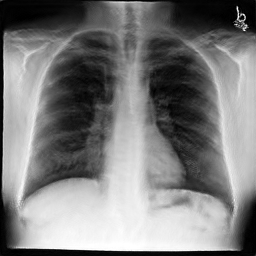

In [60]:
idx = 1
to_pil_image(img_source[idx])

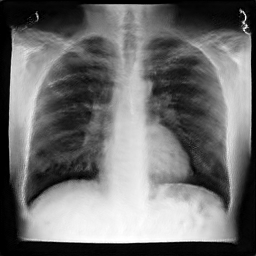

In [66]:
to_pil_image(img_recon[idx])

In [65]:
z1

tensor([[-0.1267,  0.2016,  0.3912,  ..., -0.3373,  0.1322,  0.6631],
        [-0.1267,  0.2016,  0.3912,  ..., -0.3372,  0.1321,  0.6631],
        [-0.1266,  0.2015,  0.3912,  ..., -0.3372,  0.1323,  0.6632],
        ...,
        [-0.1267,  0.2014,  0.3912,  ..., -0.3370,  0.1321,  0.6630],
        [-0.1266,  0.2015,  0.3912,  ..., -0.3372,  0.1323,  0.6631],
        [-0.1266,  0.2015,  0.3912,  ..., -0.3373,  0.1323,  0.6632]],
       grad_fn=<AddmmBackward>)